### **Import Libraries**

### **Historical Data - Succesful adaptation calculator**

In [4]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from fuzzywuzzy import process, fuzz
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.model_selection import train_test_split

import pandas as pd

def detect_transfers(df):
    """
    Identifies the season in which each player's transfer occurred.
    """
    df = df.sort_values(by=['player_id', 'season']).reset_index(drop=True)
    df['prev_club_name'] = df.groupby('player_id')['club_name'].shift(1)  # Previous club in the previous season
    df['prev_season'] = df.groupby('player_id')['season'].shift(1)  # Previous season
    df['transferred'] = (df['club_name'] != df['prev_club_name']).astype(int)  # Did the club change?
    
    return df

def calculate_adaptation_score(player, min_score=-50, max_score=100):
    """
    Calculates the Successful Adaptation Score based on:
    - Participation (comparison of minutes between seasons)
    - Offensive/defensive performance according to sub-position
    - Normalization between 0 and 1
    """
    # Calculate participation percentage based on comparison of minutes played
    prev_season_minutes = player['prev_minutes_played'] if 'prev_minutes_played' in player else 0
    season_minutes = player['minutes_played']
    
    # Avoid division by zero if there are no data from the previous season
    if prev_season_minutes > 0:
        participation_percentage = (season_minutes / prev_season_minutes) * 100
    else:
        participation_percentage = 100  # If there is no previous season data, assume 100% participation

    # Scale participation to 40% of the total score
    participation_score = participation_percentage * 0.4

    # Standardize the performance metrics of goals, conceeded_goals, assists, and clean sheets to have scores between 0 and 100 except for the ones that are already between 0 and 100
    performance_metrics = [
        'goals', 'conceeded_goals', 'assists', 'tot_clean_sheets',  
        'defense_score', 'interceptions_score', 'sprint_score',
        'crossing_score', 'short_passing_score', 'vision_score',
        'dribbling_score', 'finishing_score'
    ]

    for metric in performance_metrics:
        if metric in player and metric in ['goals', 'conceeded_goals', 'assists', 'tot_clean_sheets']:
            # Normalize the performance metrics to a score between 0 and 100
            if player[metric] < 0:
                player[metric] = 0
            elif player[metric] > 100:
                player[metric] = 100

            player[metric] = (player[metric] - min_score) / (max_score - min_score) * 100
        else:
            player[metric] =player[metric]

    # Apply the metrics to calculate the performance score

    
    position = player['field_sub_position']
    performance_score = 0

    if position == 'Goalkeeper':
        performance_score = player.get('tot_clean_sheets', 0) * 0.3 - player.get('conceeded_goals', 0) * 0.1
    elif position == 'Centre-Back':
        performance_score = player.get('defense_score', 0) * 0.3 + player.get('interceptions_score', 0) * 0.2
    elif position in ['Right-Back', 'Left-Back']:
        performance_score = player.get('sprint_score', 0) * 0.2 + player.get('crossing_score', 0) * 0.2
    elif position in ['Defensive Midfield', 'Central Midfield']:
        performance_score = player.get('short_passing_score', 0) * 0.2 + player.get('interceptions_score', 0) * 0.2
    elif position in ['Attacking Midfield', 'Left Midfield', 'Right Midfield']:
        performance_score = player.get('vision_score', 0) * 0.2 + player.get('assists', 0) * 0.3
    elif position in ['Left Winger', 'Right Winger']:
        performance_score = (
            player.get('dribbling_score', 0) * 0.2 +
            player.get('goals', 0) * 0.2 +
            player.get('assists', 0) * 0.2
        )
    elif position in ['Centre-Forward', 'Second Striker']:
        performance_score = player.get('finishing_score', 0) * 0.3 + player.get('goals', 0) * 0.3

    # Scale the performance score to 60% of the total score
    performance_score = performance_score * 0.6

    # Calculate the total score by combining participation and performance
    raw_score = participation_score + performance_score

    # Normalize the final score between 0 and 1
    adaptation_score = (raw_score - min_score) / (max_score - min_score)
    adaptation_score = max(0, min(1, adaptation_score))

    return adaptation_score

# 1. Load the data
df = pd.read_csv('CompleteDataset.csv')
df['Latitude'] = df['Latitude'].astype(str).str.replace(',', '.').astype(float)
df['Longitude'] = df['Longitude'].astype(str).str.replace(',', '.').astype(float)

# 2. Detect transfers
df = detect_transfers(df)

# 3. Calculate the total minutes per season
df['prev_minutes_played'] = df.groupby('player_id')['minutes_played'].shift(1)


# 4. Filter only the transferred players

df_transfer = df[df['transferred'] == 1].reset_index(drop=True)

# 5. Calculate the Successful Adaptation Score
df_transfer['adaptation_score'] = df_transfer.apply(calculate_adaptation_score, axis=1)

# 6. Generate the binary variable for successful adaptation
df_transfer['successful_adaptation'] = (df_transfer['adaptation_score'] >= 0.7).astype(int)

# 7. Print the results
#print(df_transfer[['player_name', 'season', 'club_name', 'field_sub_position', 'adaptation_score']])

# 8. Save the results to a new CSV file
df_transfer.to_csv('Results2.csv', index=False)




### **Logistic Regression for calculating the succesful adaptation**

Accuracy: 0.71
ROC AUC: 0.79
Axes(0.125,0.11;0.62x0.77)


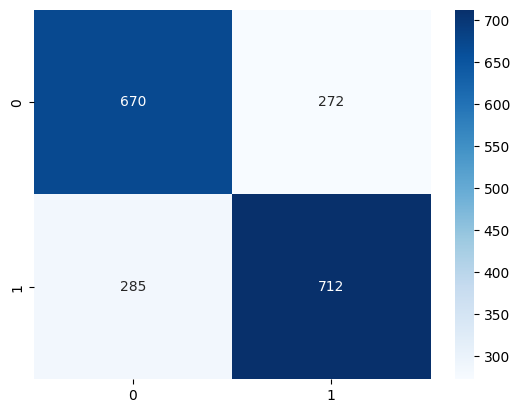

In [5]:
#!pip install fuzzywuzzy
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from fuzzywuzzy import process, fuzz
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.model_selection import train_test_split

# 1. Load the data
df = df_transfer
df=df.dropna()

# 2. Select the features and target variable
# Take out the unrequired columns
df = df.drop(columns=['player_name', 'season', 'country','club_name', 'field_position', 'field_sub_position', 'prev_club_name', 
                      'prev_season', 'transferred','pref_foot', 'adaptation_score','prev_minutes_played','player_id'])

# Features (column names without the target variable)
features = df.columns[df.columns != 'successful_adaptation']

# Target
target = 'successful_adaptation'

# 3. Split the data into training and testing sets
X = df[features]
y = df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 4. Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 5. Train a logistic regression model
model = LogisticRegression()
model.fit(X_train_scaled, y_train)

# 6. Make predictions
y_pred = model.predict(X_test_scaled)

# 7. Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, model.predict_proba(X_test_scaled)[:, 1])

# 8. Print the results
print(f'Accuracy: {accuracy:.2f}')
print(f'ROC AUC: {roc_auc:.2f}')

# 9. Confusion matrix using heat map
confusion_matrix=sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
print(confusion_matrix)
